## Reserved for library installs

In [1]:
#!pip3 install pillow

### Imports

In [2]:
import argparse
from collections import Counter
import datetime
import os
import sys
import matplotlib.pyplot as plt
from PIL import Image
import io

import torch
import torchvision
from torchvision.transforms.functional import normalize, to_tensor, resize, to_pil_image
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import BatchSizeFinder, EarlyStopping, LearningRateFinder
from pytorch_lightning import Trainer

from torchcam.utils import overlay_mask
from torchcam.methods import SmoothGradCAMpp

import config

from dataset import createConfusionMatrix
from dataset import MixtecGenders
from mixtec_model import MixtecModel

In [3]:
def _printdate(dt=datetime.datetime.now()):
    """print a date and time string containing only numbers and dashes"""

    # your code here
    if dt.hour < 10:
        hour = "0" + str(dt.hour)
    else:
        hour = str(dt.hour)

    if dt.minute < 10:
        minute = "0" + str(dt.minute)
    else:
        minute = str(dt.minute)

    d = "{}-{}-{}-{}-{}".format(str(dt.month), str(dt.day), str(dt.year), hour, minute)
    return d

In [4]:
class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        pl_module.logger.log_metrics(metrics, step=trainer.global_step)
        for k, v in metrics.items():
            pl_module.logger.log_metrics({k: v}, step=trainer.global_step)
            pl_module.logger.experiment.add_scalar(k, v, trainer.global_step)

In [5]:
# Get the data set
# Using only one worker is faster
dataset = MixtecGenders(num_workers=1, batch_size=config.BATCH_SIZE)

#print(dict(Counter(dataset.targets)))

logger = TensorBoardLogger(save_dir="../runs", name="cam_test", default_hp_metric=False)

# Configure the model
#model = NN(config.BATCH_SIZE, config.LEARNING_RATE)
model = MixtecModel(learning_rate=config.LEARNING_RATE, num_epoch=config.EPOCHS, model_name="resnet18")
# model.set_reference_dataloader(dataset.reference_dataloader)

In [6]:
# Train the model
early_stopping = EarlyStopping(
    monitor="val_f1",
    # min_delta=1e-6,
    stopping_threshold=1e-4,
    # divergence_threshold=9.0,
    check_finite=True,
)

In [6]:
trainer = Trainer(devices="auto", accelerator="auto", #auto_lr_find=True,
                    logger=logger, log_every_n_steps=1, enable_progress_bar=True,
                    min_epochs=1, max_epochs=config.EPOCHS,
                    callbacks=[
                    #   BatchSizeFinder(init_val=64),
                    # LearningRateFinder(),
                    #early_stopping,
                    # LoggingCallback(),
                        ])

# Tune the model
# trainer.tune(model, datamodule=dataset)


# Run the evaluation

fitresults = trainer.fit(model, datamodule=dataset)

# Create and log confusion matrix
logger.experiment.add_figure("Confusion matrix", createConfusionMatrix(dataset.train_dataloader(), model), config.EPOCHS)
logger.experiment.add_figure("Confusion matrix", createConfusionMatrix(dataset.val_dataloader(), model), config.EPOCHS)

valresults = trainer.validate(model, datamodule=dataset)
print('-'*80)
print(f"{valresults=}")
print('-'*80)
#print(trainer.predict(model, datamodule=dataset))
#trainer.test(model, dm)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: ../runs/cam_test


Training Set: Counter({1: 543, 0: 229})
Validation Set: Counter({1: 262, 0: 123})


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | model         | ResNet           | 11.7 M
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/home/alexwebber/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/alexwebber/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Detected the following values in `preds`: tensor([ 38,  47,  51, 107, 112, 431, 443, 452, 459, 464, 465, 496, 516, 529,
        549, 584, 591, 601, 610, 611, 619, 689, 691, 697, 710, 787, 812, 857,
        868, 892, 893, 917, 921], device='cuda:0') but expected only the following values [0,1] since `preds` is a label tensor.

### Male heatmap

In [13]:
def transform_image(image: Image) -> Image:
    to_tensor        = transforms.ToTensor()
    to_square        = transforms.Resize((224, 224), antialias=True)
    to_three_channel = transforms.Lambda(lambda x: x[:3])

    image            = to_three_channel(to_square(to_tensor(image)))
    
    return image

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)

  return image

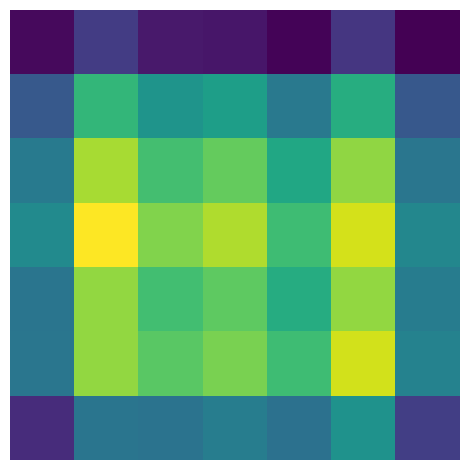

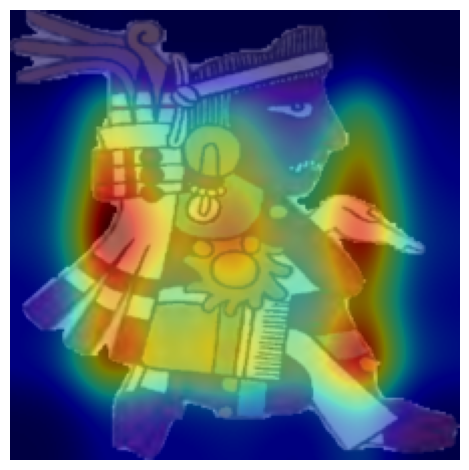

In [18]:
# Run the test
ref_img_male = Image.open("../reference_images/male/067-a-09.png")
to_tensor        = transforms.ToTensor()
to_square        = transforms.Resize((224, 224), antialias=True)
to_three_channel = transforms.Lambda(lambda x: x[:3])

ref_img_male     = to_three_channel(to_square(to_tensor(ref_img_male)))

# Preprocess it for your chosen model
input_tensor = normalize(resize(ref_img_male, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

cam_extractor = SmoothGradCAMpp(model, 'model.layer4')

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))


# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item())

plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()
    
# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(ref_img_male), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

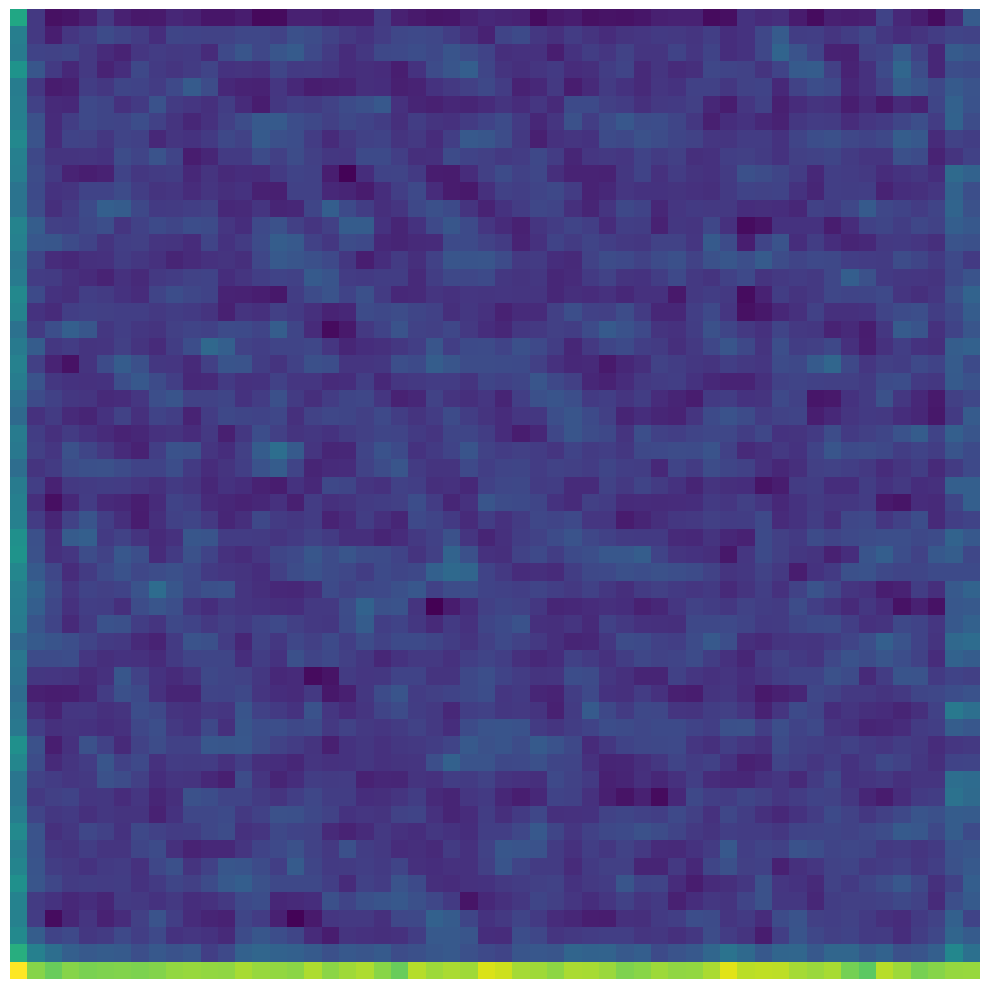

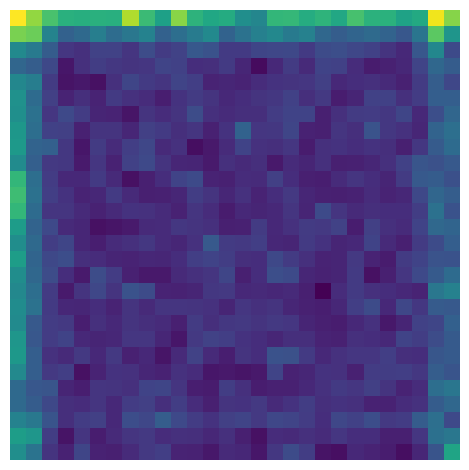

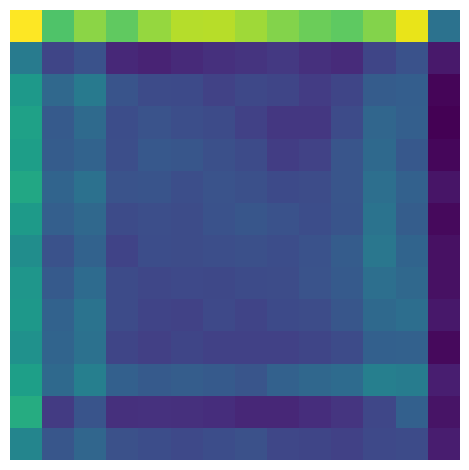

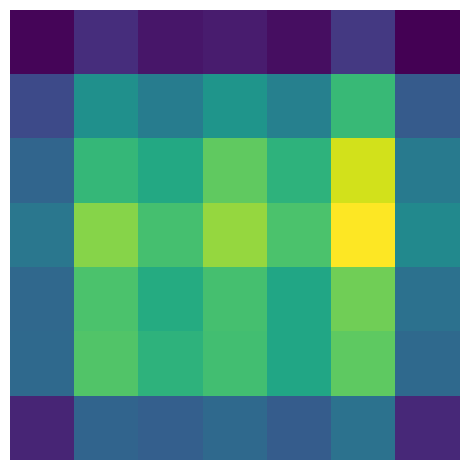

NameError: name 'tf' is not defined

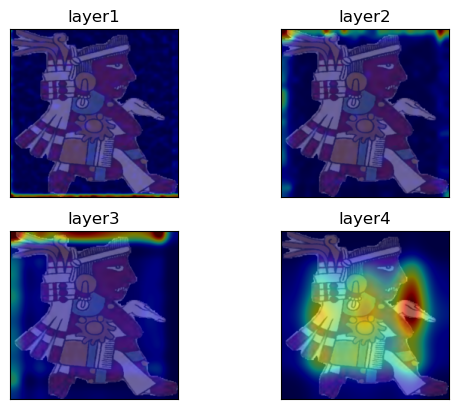

In [26]:
images_from_layers_list = []

## TODO: This is currently hardcoded for RESNET18; need to make it dynamic for any model.
layer_list = ['layer1', 'layer2', 'layer3', 'layer4']

#print(model.eval())

# Preprocess it for your chosen model
## TODO: Probably need to make this dynamic too
ref_img_male = Image.open("../reference_images/male/067-a-09.png")
ref_img_male = transform_image(ref_img_male)

input_tensor = normalize(resize(ref_img_male, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))

figure = plt.figure(figsize=(10,10))

for layer in layer_list:

    layer = 'model.' + layer

    cam_extractor = SmoothGradCAMpp(model, layer)
    
    out = model(input_tensor.unsqueeze(0))

    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item())

    plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(ref_img_male), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

    images_from_layers_list.append(result)

for i in range(4):
        # Start next subplot.
        plt.subplot(2, 2, i + 1, title=layer_list[i])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images_from_layers_list[i], cmap=plt.cm.binary)


tensor_board_output = plot_to_image(figure)

print(tensor_board_output)

### Female heatmap

In [9]:
def reference_class_activation_output():
    model.eval()
    
    # Run the test
    ref_img_female = Image.open("../reference_images/female/003-a-06.png")
    to_tensor        = transforms.ToTensor()
    to_square        = transforms.Resize((224, 224), antialias=True)
    to_three_channel = transforms.Lambda(lambda x: x[:3])

    ref_img_female   = to_three_channel(to_square(to_tensor(ref_img_female)))

    # Preprocess it for your chosen model
    input_tensor = normalize(resize(ref_img_female, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    cam_extractor = SmoothGradCAMpp(model, 'model.layer4')

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))

    print(out)

    print(out.squeeze(0).argmax().item())

    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item())

    plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(ref_img_female), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    # Display it
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
    
    model.train()